In [ ]:
# compatible version
!pip install gym==0.26.2
!pip install mujoco==2.3.0

In [1]:
# packages for rl environment and rendering
import gym
import mujoco
import glfw

In [2]:
# necessary packages for model
import os
import json
import pickle
import time
from tqdm import tqdm
import math
import numpy as np
import random
import torch
import einops
from einops.layers.torch import Rearrange
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

**A simple walker 2d agent with random policy** 

for testing if environment are all ready

**Model Architecute and Details Illustration**

In [3]:
# Define Mish activation function
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

# Sinusoidal Position Embeddings
# Input Shape: t of shape [batch_size]
# Output Shape: [batch_size, dim]
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# Downsampling layer
class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

# Upsampling layer
class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)

# Convolutional block
# Input Shape: x of shape [batch_size, in_channels, seq_len]
# Output Shape: [batch_size, out_channels, seq_len]
class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            Rearrange('batch channels horizon -> batch channels 1 horizon'),
            nn.GroupNorm(n_groups, out_channels),
            Rearrange('batch channels 1 horizon -> batch channels horizon'),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


#-----------------------------------------------------------------------------#
#--------------------------------- attention ---------------------------------#
#-----------------------------------------------------------------------------#

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
        
class LayerNorm(nn.Module):
    def __init__(self, dim, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1))

    def forward(self, x):
        var = torch.var(x, dim=1, unbiased=False, keepdim=True)
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) / (var + self.eps).sqrt() * self.g + self.b
        
# Pre-normalization wrapper
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# Linear Attention (optional, can be simplified)
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv1d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv1d(hidden_dim, dim, 1)

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: einops.rearrange(t, 'b (h c) d -> b h c d', h=self.heads), qkv)
        q = q * self.scale

        k = k.softmax(dim = -1)
        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = einops.rearrange(out, 'b h c d -> b (h c) d')
        return self.to_out(out)


#-----------------------------------------------------------------------------#
#---------------------------- diffusion model---------------------------------#
#-----------------------------------------------------------------------------#

# Residual Temporal Block
# Input Shapes: x: [batch_size, inp_channels, seq_len], t: [batch_size, embed_dim] (time embeddings)
# Output Shape: [batch_size, out_channels, seq_len]
class ResidualTemporalBlock(nn.Module):
    def __init__(self, inp_channels, out_channels, embed_dim, horizon, kernel_size=5):
        super().__init__()
        self.blocks = nn.ModuleList([
            Conv1dBlock(inp_channels, out_channels, kernel_size),
            Conv1dBlock(out_channels, out_channels, kernel_size),
        ])

        self.time_mlp = nn.Sequential(
            Mish(),
            nn.Linear(embed_dim, out_channels),
            Rearrange('batch c -> batch c 1'),
        )

        self.residual_conv = nn.Conv1d(inp_channels, out_channels, 1) \
            if inp_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        # x: (batch_size, channels, seq_len)
        # t: (batch_size, embed_dim)
        out = self.blocks[0](x) + self.time_mlp(t) # [batch_size, out_channels, seq_len]
        out = self.blocks[1](out)
        return out + self.residual_conv(x)

# Temporal U-Net
class TemporalUnet(nn.Module):
    def __init__(self, horizon, transition_dim, cond_dim, dim=32, dim_mults=(1, 2, 4, 8), attention=False):
        super().__init__()

        # dims: A list of channel dimensions at each level, computed as [transition_dim] + [dim * m for m in dim_mults]
        # in_out: A list of tuples pairing input and output dimensions at each level, e.g., [(transition_dim, dim), (dim, dim * 2), ...]
        dims = [transition_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        # Time embedding, map scalar time steps to embeddings.
        # [batch_size] → [batch_size, dim]
        time_dim = dim
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(dim),
            nn.Linear(dim, dim * 4),
            Mish(),
            nn.Linear(dim * 4, dim),
        )

        # Downsampling Blocks (self.downs)
        # Each block consists of two ResidualTemporalBlocks, optional attention, and a Downsample1d.
        # Reduces the sequence length and increases the channel dimension.
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)
        current_horizon = horizon

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(nn.ModuleList([
                ResidualTemporalBlock(dim_in, dim_out, embed_dim=time_dim, horizon=current_horizon),
                ResidualTemporalBlock(dim_out, dim_out, embed_dim=time_dim, horizon=current_horizon),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))) if attention else nn.Identity(),
                Downsample1d(dim_out) if not is_last else nn.Identity()
            ]))
            if not is_last:
                current_horizon = current_horizon // 2

        # Middle Blocks (self.mid_block1, self.mid_attn, self.mid_block2):
        # Process the lowest-resolution representation
        mid_dim = dims[-1]
        self.mid_block1 = ResidualTemporalBlock(mid_dim, mid_dim, embed_dim=time_dim, horizon=current_horizon)
        self.mid_attn = Residual(PreNorm(mid_dim, LinearAttention(mid_dim))) if attention else nn.Identity()
        self.mid_block2 = ResidualTemporalBlock(mid_dim, mid_dim, embed_dim=time_dim, horizon=current_horizon)

        # Upsampling Blocks (self.ups)
        # Mirror the downsampling path, using Upsample1d to increase sequence length and decrease channel dimensions.
        # Skip connections concatenate features from the downsampling path.
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)
            self.ups.append(nn.ModuleList([
                ResidualTemporalBlock(dim_out * 2, dim_in, embed_dim=time_dim, horizon=current_horizon),
                ResidualTemporalBlock(dim_in, dim_in, embed_dim=time_dim, horizon=current_horizon),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))) if attention else nn.Identity(),
                Upsample1d(dim_in) if not is_last else nn.Identity()
            ]))
            if not is_last:
                current_horizon = current_horizon * 2

        # Final Convolution (self.final_conv):
        # Maps back to the original transition_dim.
        self.final_conv = nn.Sequential(
            Conv1dBlock(dim, dim, kernel_size=5),
            nn.Conv1d(dim, transition_dim, 1),
        )

    def forward(self, x, cond, time):
        # x: (batch_size, horizon, transition_dim)
        x = einops.rearrange(x, 'b h t -> b t h')
        t = self.time_mlp(time)
        h = []

        for resnet1, resnet2, attn, downsample in self.downs:
            x = resnet1(x, t)
            x = resnet2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for resnet1, resnet2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet1(x, t)
            x = resnet2(x, t)
            x = attn(x)
            x = upsample(x)

        x = self.final_conv(x)
        x = einops.rearrange(x, 'b t h -> b h t')
        return x


#-----------------------------------------------------------------------------#
#-------------------------------- value model---------------------------------#
#-----------------------------------------------------------------------------#

# Value Function
class ValueFunction(nn.Module):
    def __init__(self, horizon, transition_dim, cond_dim, dim=32, dim_mults=(1, 2, 4, 8), out_dim=1):
        super().__init__()

        dims = [transition_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        time_dim = dim
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(dim),
            nn.Linear(dim, dim * 4),
            Mish(),
            nn.Linear(dim * 4, dim),
        )

        self.blocks = nn.ModuleList([])
        num_resolutions = len(in_out)
        current_horizon = horizon

        for ind, (dim_in, dim_out) in enumerate(in_out):
            self.blocks.append(nn.ModuleList([
                ResidualTemporalBlock(dim_in, dim_out, embed_dim=time_dim, horizon=current_horizon),
                ResidualTemporalBlock(dim_out, dim_out, embed_dim=time_dim, horizon=current_horizon),
                Downsample1d(dim_out)
            ]))
            current_horizon = max(current_horizon // 2, 1)

        mid_dim = dims[-1]
        mid_dim_2 = mid_dim // 2
        mid_dim_3 = mid_dim // 4

        self.mid_block1 = ResidualTemporalBlock(mid_dim, mid_dim_2, embed_dim=time_dim, horizon=current_horizon)
        self.mid_down1 = Downsample1d(mid_dim_2)
        current_horizon = max(current_horizon // 2, 1)

        self.mid_block2 = ResidualTemporalBlock(mid_dim_2, mid_dim_3, embed_dim=time_dim, horizon=current_horizon)
        self.mid_down2 = Downsample1d(mid_dim_3)
        current_horizon = max(current_horizon // 2, 1)

        fc_dim = mid_dim_3 * current_horizon

        self.final_block = nn.Sequential(
            nn.Linear(fc_dim + time_dim, fc_dim // 2),
            Mish(),
            nn.Linear(fc_dim // 2, out_dim),
        )

    def forward(self, x, cond, time):
        # x: (batch_size, horizon, transition_dim)
        x = einops.rearrange(x, 'b h t -> b t h')
        t = self.time_mlp(time)
        
        # Check the shape of x
        batch_size = x.size(0)  # Get the batch size from x
        
        # Adjust dimensions of t to match x
        if t.size(0) != batch_size:
            t = t.expand(batch_size, -1)  # Expand t to have the same batch size as x

        for resnet1, resnet2, downsample in self.blocks:
            x = resnet1(x, t)
            x = resnet2(x, t)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_down1(x)

        x = self.mid_block2(x, t)
        x = self.mid_down2(x)

        x = x.view(len(x), -1)
        out = self.final_block(torch.cat([x, t], dim=-1))

        return out


**Load Trajectory Dataset**

In [4]:
class TrajectoryDataset(Dataset):
    def __init__(self, dataset, window_size, gamma=0.99):
        super(TrajectoryDataset, self).__init__()
        self.data = []  # Initialize an empty list to store processed data
        self.window_size = window_size
        self.gamma = gamma

        # Stack all observations and actions to calculate global min and max
        all_data = np.concatenate([np.concatenate((traj['observations'], traj['actions']), axis=-1) for traj in dataset], axis=0)

        # Calculate global min and max for normalization across the dataset
        self.mins = all_data.min(axis=0)
        self.maxs = all_data.max(axis=0)

        # Now re-process the dataset to normalize the states
        for traj in dataset:
            observations = traj['observations']  # Shape (num_steps, 17)
            actions = traj['actions']  # Shape (num_steps, 6)
            rewards = traj['rewards']


            observations = 2 * (observations - self.mins[:17])/(self.maxs[:17]-self.mins[:17]) - 1
            
            # Combine normalized observations and actions
            trajectory = np.concatenate((observations, actions), axis=-1)

            num_steps = len(rewards)

            # Add random start offset for diverse window sampling
            start_offset = np.random.randint(0, self.window_size)
            for start in range(start_offset, num_steps, self.window_size):
                end = min(start + self.window_size, num_steps)

                # Only consider full windows
                if end - start < self.window_size:
                    continue

                partial_trajectory = trajectory[start:end]

                # Calculate discounted cumulative reward for this window
                cumulative_reward = 0
                window_value = 0
                for t in reversed(range(start, end)):
                    cumulative_reward = rewards[t] + self.gamma * cumulative_reward
                    window_value = cumulative_reward

                # Append the processed window (partial trajectory) and its cumulative reward
                self.data.append((partial_trajectory, window_value))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        trajectory, value = self.data[idx]
        return torch.tensor(trajectory, dtype=torch.float32), torch.tensor(value, dtype=torch.float32)

    def normalize(self, x):
        # Normalize to [0, 1]
        x = (x - self.mins) / (self.maxs - self.mins)
        # Scale to [-1, 1]
        x = 2 * x - 1
        return x

    def unnormalize(self, x, eps=1e-4):
        '''
            x : [ -1, 1 ]
        '''
        if x.max() > 1 + eps or x.min() < -1 - eps:
            x = np.clip(x, -1, 1)

        # Convert back to [0, 1]
        x = (x + 1) / 2.

        return x * (self.maxs - self.mins) + self.mins

# Custom collate function for handling batches
def collate_fn(batch):
    # Stack trajectories and values into tensors
    batch_trajectories = torch.stack([trajectory for trajectory, value in batch])
    batch_values = torch.stack([value for trajectory, value in batch])

    return batch_trajectories, batch_values


**Main Training Loop**

In [5]:
def linear_schedule(num_timesteps):
    beta_start = 1e-4
    beta_end = 0.02
    betas = torch.linspace(beta_start, beta_end, num_timesteps)
    return betas

def cosine_beta_schedule(timesteps, s=0.008, dtype=torch.float32):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = np.linspace(0, steps, steps)
    alphas_cumprod = np.cos(((x / steps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas_clipped = np.clip(betas, a_min=0, a_max=0.999)
    return torch.tensor(betas_clipped, dtype=dtype)

def schedule(method, T, is_train, offset=0):
    if is_train:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    else:
        device = torch.device('cpu')
    beta_t = method(T).to(device)
    alpha_t = 1. - beta_t
    alpha_t = torch.max(alpha_t, torch.tensor(offset).to(device))
    alpha_bar_t = torch.cumprod(alpha_t, dim=0)
    alpha_bar_tm1 = torch.cat((torch.tensor([1.0], device=device), alpha_bar_t[:-1]))
    sigma_t_squared = (1 - alpha_bar_tm1) / (1 - alpha_bar_t) * beta_t
    sigma_t = torch.sqrt(sigma_t_squared)
    return beta_t, alpha_t, alpha_bar_t, alpha_bar_tm1, sigma_t

def train(config, dataset):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available 
    print(device)
    
    # Initialize models
    if config['load_checkpoint']:
        if not config['predict_epsilon']:
            method = 'trajectory'
        else:
            method = 'epsilon'
        models = load_model(config, config['checkpoint_epoch'], method)  
        
        value_model = models['value_model'].to(device)
        diffusion_model = models['diffusion_model'].to(device)
    else:
        value_model = ValueFunction(
            horizon=config['horizon'],
            transition_dim=config['transition_dim'],
            cond_dim=config['cond_dim'],
            dim=config['dim'],
            dim_mults=config['dim_mults'],
            out_dim=1,
        ).to(device)
        diffusion_model = TemporalUnet(
            horizon=config['horizon'],
            transition_dim=config['transition_dim'],
            cond_dim=config['cond_dim'],
            dim=config['dim'],
            dim_mults=config['dim_mults'],
            attention=config['attention'],
        ).to(device)

    value_model.train()
    diffusion_model.train()

    dataset = TrajectoryDataset(dataset, config['horizon'])
    dataloader = DataLoader(dataset, config['batch_size'], shuffle=True, collate_fn=collate_fn)

    base_losses = []
    base_t_losses = []
    a0_losses = []
    value_losses = []
    value_t_losses = []
    

    diffusion_optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=config['learning_rate'])
    value_optimizer = torch.optim.Adam(value_model.parameters(), lr=config['learning_rate'])
    
    T_d = config['T_diffusion']
    beta_t, alpha_t, alpha_bar_t, alpha_bar_tm1, sigma_t = schedule(cosine_beta_schedule, T_d, True, 0)

    last_n = 500
    patience = 2  # Stop after 5 epochs of no improvement

    def q_sample(tau_0, t, epsilon):
        # shape tau_0 = (batch_size, seq_len, state_dim + action_dim)
        tau_t = torch.sqrt(alpha_bar_t[t]) * tau_0 + torch.sqrt(1 - alpha_bar_t[t]) * epsilon
        return tau_t

    def conditioning(tau, s):
        tau[:, 0, :-config['action_dim']] = s
        return tau

    # Define the total iterations for progress bar
    total_iterations = config['base_num_epoch'] * len(dataloader)
    best_loss = float('inf')
    no_improvement_epochs = 0
    with tqdm(total=total_iterations, desc="Training Base Diffusion Model", mininterval=1) as pbar:
        for epoch in range(config['base_num_epoch']):
            for iteration, (tau_0, value) in enumerate(dataloader):
                tau_0, value = tau_0.to(device), value.to(device)  # Move data to GPU
                t = random.randint(1, T_d) - 1 # zero-indexing correction
                epsilon = torch.randn_like(tau_0).to(device)  # Move random noise to GPU
                tau_t = q_sample(tau_0, t, epsilon)
                tau_t = conditioning(tau_t, tau_0[:, 0, :-config['action_dim']]) # condition on initial noiseless state
                if config['predict_epsilon']:
                    epsilon_pred = diffusion_model(tau_t, 0, torch.tensor([t], dtype=torch.float32, device=device))
                    diffusion_loss = F.mse_loss(epsilon, epsilon_pred)
                else:
                    tau_0_pred = diffusion_model(tau_t, 0, torch.tensor([t], dtype=torch.float32, device=device))
                    diffusion_loss = F.mse_loss(tau_0, tau_0_pred)
                diffusion_optimizer.zero_grad()
                diffusion_loss.backward()
                diffusion_optimizer.step()

                base_losses.append(diffusion_loss.detach().item())
                base_t_losses.append((diffusion_loss.detach().item(), t))
                
                # stop training when Loss stops improving
                if len(base_losses) > last_n:
                    last_n_loss = np.mean(base_losses[-last_n:])
                    mean_loss = np.mean(base_losses)
                    # Update the progress bar description
                    pbar.set_description(f"Epoch {epoch}, Iter {iteration}, Diff Loss {mean_loss:.4f}, Last {last_n} Diff Loss {last_n_loss:.4f}")
                    pbar.update()

            if (epoch+1) % 100 == 0:
                if config['load_checkpoint']:
                    save_model(diffusion_model, epoch+1+config['checkpoint_epoch'], 'diffusion_model', save_path='model_checkpoints')
                else:
                    save_model(diffusion_model, epoch+1, 'diffusion_model', save_path='model_checkpoints')

    total_iterations = config['value_num_epoch'] * len(dataloader)
    best_loss = float('inf')
    no_improvement_epochs = 0
    with tqdm(total=total_iterations, desc="Training Value Model", mininterval=1) as pbar:
        for epoch in range(config['value_num_epoch']):
            for iteration, (tau_0, value) in enumerate(dataloader):
                tau_0, value = tau_0.to(device), value.to(device)  # Move data to GPU
                t = random.randint(1, T_d) - 1  # zero-indexing correction
                epsilon = torch.randn_like(tau_0).to(device)  # Move random noise to GPU
                tau_t = q_sample(tau_0, t, epsilon)
                tau_t = conditioning(tau_t, tau_0[:, 0, :-config['action_dim']]) # condition on initial noiseless state
                value_pred = value_model(tau_t, 0, torch.tensor([t], dtype=torch.float32, device=device))
                value_loss = F.mse_loss(value_pred, value.unsqueeze(1))
                value_optimizer.zero_grad()
                value_loss.backward()
                value_optimizer.step()

                value_losses.append(value_loss.detach().item())
                value_t_losses.append((value_loss.detach().item(), t))
                
                if len(value_losses) > last_n:
                    last_n_loss = np.mean(value_losses[-last_n:])
                    mean_loss = np.mean(value_losses)
                    # Update the progress bar description
                    pbar.set_description(f"Epoch {epoch}, Iter {iteration}, Value Loss {mean_loss:.4f}, Last {last_n} value Loss {last_n_loss:.4f}")
                    pbar.update()
                    
            if (epoch+1) % 100 == 0:
                save_model(value_model, epoch+1, 'value_model', save_path='model_checkpoints')

    print(torch.cuda.memory_allocated())  # Should show much lower usage now
    print(torch.cuda.memory_reserved())

    # Return models and loss history for further testing or analysis
    models = {
        'value_model': value_model,
        'diffusion_model': diffusion_model
    }
    
    loss_history = {
        'base_losses': base_losses,
        'value_losses': value_losses,
        'a0_losses': a0_losses,
        'value_t_losses': value_t_losses,
        'base_t_losses': base_t_losses
    }
    
    return models, loss_history

In [8]:
def save_model(model, epoch, model_name, save_path):
    """
    Save a model's state_dict to a specified path.
    
    Args:
    - model (torch.nn.Module): The model to be saved.
    - epoch (int): The current epoch number.
    - save_path (str): The directory where the model should be saved.
    - model_name (str): A name or identifier to differentiate models (e.g., "diffusion_model" or "value_model").
    """
    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)
    
    # Construct the filename using the model_name and epoch
    model_filename = f"{model_name}_epoch_{epoch}.pth"
    model_filepath = os.path.join(save_path, model_filename)
    
    # Save the model's state_dict
    torch.save(model.state_dict(), model_filepath)
    
    print(f"Saved {model_name} at epoch {epoch} to {model_filepath}")
    
def load_model(config, epoch, method, save_path='model_checkpoints'):
    value_model = ValueFunction(
        horizon=config['horizon'],
        transition_dim=config['transition_dim'],
        cond_dim=config['cond_dim'],
        dim=config['dim'],
        dim_mults=config['dim_mults'],
        out_dim=1,
    )
    diffusion_model = TemporalUnet(
        horizon=config['horizon'],
        transition_dim=config['transition_dim'],
        cond_dim=config['cond_dim'],
        dim=config['dim'],
        dim_mults=config['dim_mults'],
        attention=config['attention'],
    )
    
    models = {
        'value_model': value_model,
        'diffusion_model': diffusion_model
    }
    
    # Use the specific 'epoch' for loading the model
    for model_name, model in models.items():
        model_load_path = os.path.join(save_path, f"{method}")  # Changed from total_epoch to epoch
        model_load_path = os.path.join(model_load_path, f"{model_name}_epoch_{epoch}.pth")
        try:
            model.load_state_dict(torch.load(model_load_path))
            print(f"Model {model_name} loaded from {model_load_path}")
        except FileNotFoundError:
            print(f"Failed to load {model_name} from {model_load_path}")

    return models
    
    
# Configuration
latent_dim = 23
cond_dim = 0
config = {
    'horizon': 8,  # Sequence length
    'T_diffusion': 20,
    'transition_dim': latent_dim,
    'cond_dim': cond_dim, 
    'dim': 32,  # Hidden dimension
    'dim_mults': (1, 2, 4, 8),
    'state_dim': 17,
    'action_dim': 6,
    'attention': True,
    'batch_size': 32,
    'learning_rate': 4e-5,
    'value_num_epoch': 100,
    'base_num_epoch': 100,
    'predict_epsilon': False,
    'load_checkpoint': False,
    'checkpoint_epoch': 500
}

# Load dataset
#with open('walker2d-expert-v2.pkl', 'rb') as f:
with open('walker2d-medium-v2.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [ ]:
print(torch.cuda.memory_allocated())  # Should show much lower usage now
print(torch.cuda.memory_reserved())

models, loss_history = train(config, dataset)

0
0
cuda


Epoch 64, Iter 3228, Diff Loss 0.0285, Last 500 Diff Loss 0.0194:  65%|███▏ | 250664/387400 [1:55:21<1:11:37, 31.82it/s]

In [12]:
# old training log
# horizon = 32, trajectory, medium

71115776
247463936
cuda


Epoch 100, Iter 7, Diff Loss 0.0449, Last 500 Diff Loss 0.0316:  20%|█▉        | 93707/471000 [37:23<2:35:14, 40.51it/s]

Saved diffusion_model at epoch 99 to model_checkpoints/diffusion_model_epoch_99.pth


Epoch 200, Iter 5, Diff Loss 0.0366, Last 500 Diff Loss 0.0258:  40%|██▊    | 187905/471000 [1:21:41<2:23:27, 32.89it/s]

Saved diffusion_model at epoch 199 to model_checkpoints/diffusion_model_epoch_199.pth


Epoch 300, Iter 5, Diff Loss 0.0324, Last 500 Diff Loss 0.0225:  60%|████▏  | 282105/471000 [2:10:59<1:41:49, 30.92it/s]

Saved diffusion_model at epoch 299 to model_checkpoints/diffusion_model_epoch_299.pth


Epoch 400, Iter 4, Diff Loss 0.0296, Last 500 Diff Loss 0.0199:  80%|███████▏ | 376304/471000 [3:06:01<58:07, 27.16it/s]

Saved diffusion_model at epoch 399 to model_checkpoints/diffusion_model_epoch_399.pth


Epoch 499, Iter 941, Diff Loss 0.0274, Last 500 Diff Loss 0.0177: 100%|██████▉| 470500/471000 [4:06:18<00:15, 31.84it/s]


Saved diffusion_model at epoch 499 to model_checkpoints/diffusion_model_epoch_499.pth


Epoch 14, Iter 727, Value Loss 225.3797, Last 500 value Loss 46.7244:   3%|    | 13415/471000 [03:06<1:42:13, 74.60it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 29, Iter 424, Value Loss 129.2257, Last 500 value Loss 25.7708:   6%|▏   | 27242/471000 [06:15<1:46:34, 69.40it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 44, Iter 402, Value Loss 93.7321, Last 500 value Loss 22.9891:   9%|▍    | 41350/471000 [09:36<1:45:06, 68.13it/s]IOPu

Saved value_model at epoch 299 to model_checkpoints/value_model_epoch_299.pth


Epoch 301, Iter 673, Value Loss 26.1606, Last 500 value Loss 9.4057:  60%|█▏| 283715/471000 [1:23:15<1:12:11, 43.24it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 311, Iter 365, Value Loss 25.6745, Last 500 value Loss 10.2062:  62%|▌| 292827/471000 [1:26:47<1:11:46, 41.38it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 320, Iter 639, Value Loss 25.2253, Last 500 value Loss 10.2595:  64%|▋| 301579/471000 [1:30:14<1:06:08, 42.69it/s]IOPu

Saved value_model at epoch 399 to model_checkpoints/value_model_epoch_399.pth


Epoch 400, Iter 865, Value Loss 22.0562, Last 500 value Loss 9.8229:  80%|███▏| 377165/471000 [2:02:11<40:35, 38.52it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 409, Iter 605, Value Loss 21.7740, Last 500 value Loss 9.3185:  82%|███▎| 385384/471000 [2:05:45<38:23, 37.17it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 418, Iter 227, Value Loss 21.5019, Last 500 value Loss 8.5273:  84%|███▎| 393483/471000 [2:09:24<34:55, 37.00it/s]IOPu

Saved value_model at epoch 499 to model_checkpoints/value_model_epoch_499.pth
179405824
272629760


**Testing**

initial alpha_bar_t s: tensor(0.9920) tensor(0.9721)
Final alpha_bar_t: tensor(6.0596e-06)
20


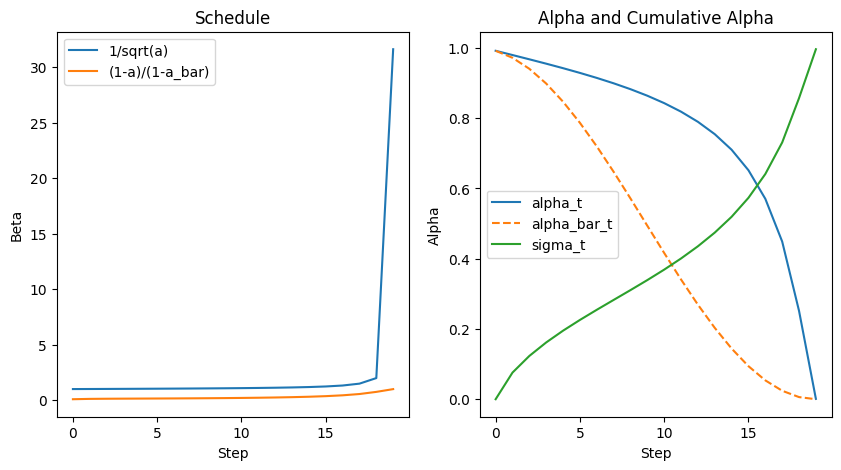

In [8]:
beta_t, alpha_t, alpha_bar_t, alpha_bar_tm1, sigma_t = schedule(cosine_beta_schedule, 20, False, 0.00)
print("initial alpha_bar_t s:", alpha_bar_t[0], alpha_bar_t[1])
print("Final alpha_bar_t:", alpha_bar_t[-1])
print(len(beta_t))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(1/torch.sqrt(alpha_t), label='1/sqrt(a)')
plt.plot((1-alpha_t)/torch.sqrt(1-alpha_bar_t), label='(1-a)/(1-a_bar)')
plt.title('Schedule')
plt.xlabel('Step')
plt.ylabel('Beta')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(alpha_t, label='alpha_t')
plt.plot(alpha_bar_t, label='alpha_bar_t', linestyle='--')
plt.plot(sigma_t, label='sigma_t')
plt.title('Alpha and Cumulative Alpha')
plt.xlabel('Step')
plt.ylabel('Alpha')
plt.legend()
plt.show()

**Load Pretrained Models**

In [20]:
predict_epsilon = False

In [111]:
method = 'trajectory' if not predict_epsilon else 'epsilon'
models = load_model(config, 500, method)  

value_model = models['value_model']
diffusion_model = models['diffusion_model']

/tmp/ipykernel_2513016/3197886943.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))


Model value_model loaded from model_checkpoints/trajectory/value_model_epoch_500.pth
Model diffusion_model loaded from model_checkpoints/trajectory/diffusion_model_epoch_500.pth


In [127]:
# Load dataset
#with open('walker2d-expert-v2.pkl', 'rb') as f:
with open('walker2d-medium-v2.pkl', 'rb') as f:
#with open('walker2d_v4_ppo_1000k.pkl', 'rb') as f:
    raw_dataset = pickle.load(f)

dataset = TrajectoryDataset(raw_dataset, config['horizon'])
dataloader = DataLoader(dataset, config['batch_size'], shuffle=True, collate_fn=collate_fn)

In [106]:
device = 'cpu'

T_d = config['T_diffusion']
beta_t, alpha_t, alpha_bar_t, alpha_bar_tm1, sigma_t = schedule(cosine_beta_schedule, T_d, False, 0)

def p_sample(x, t, predict_epsilon = True):
    x_recon = diffusion_model(x, 0, torch.tensor([t], dtype=torch.float32, device=device))
    if predict_epsilon:
        x_recon = (x - torch.sqrt(1-alpha_bar_t[t]) * x_recon) / torch.sqrt(alpha_bar_t[t])
    x_recon.clamp_(-1., 1.)
    model_mean, _, model_log_variance = q_posterior(x_recon, x, t)
    model_std = torch.exp(0.5 * model_log_variance)
    
    if t != 0:
        noise = torch.randn_like(x)
    else:
        noise = torch.zeros_like(x)

    return model_mean + model_std * noise

def q_posterior(x_start, x_t, t):
    posterior_mean = (beta_t[t]*torch.sqrt(alpha_bar_tm1[t])/(1-alpha_bar_t[t]))*x_start + (torch.sqrt(alpha_bar_t[t])*(1-alpha_bar_tm1[t])//(1-alpha_bar_t[t]))*x_t
    posterior_variance = beta_t[t]*(1-alpha_bar_tm1[t])/(1-alpha_bar_t[t])
    posterior_log_variance_clipped = torch.log(torch.clamp(posterior_variance, min=1e-20))
    return posterior_mean, posterior_variance, posterior_log_variance_clipped

def PlanningTrajectory(s,config, predict_epsilon):    
    T_d = config['T_diffusion']
    tau_t  = torch.randn(1, config['horizon'], config['transition_dim'])
    tau_t[0, 0, :-config['action_dim']] = s

    tau_unguided = []
    tau_guided = []
    tau_t_u = tau_t

    for t in reversed(range(0,T_d)):
        tau_t_u = p_sample(tau_t_u, t, predict_epsilon)
        tau_t_u[0, 0, :-config['action_dim']] = s
        
        # Gradient-Based Guidance
        tau_t.requires_grad_(True)
        # Predict tau_{t-1} using the diffusion model
        tau_t = p_sample(tau_t, t, predict_epsilon)
    
        # Compute the gradient of the value model with respect to tau_t
        value = value_model(tau_t, 0, torch.tensor([t], dtype=torch.float32, device=device))
        #print(value.shape)
        value_grad = torch.autograd.grad(value.sum(), tau_t)[0]
    
        # Adjust the sample using the value gradient
        guidance_scale = 0.1  # Hyperparameter to control guidance strength
        tau_t = tau_t + guidance_scale * value_grad
        tau_t[0, 0, :-config['action_dim']] = s
    
        # Move to the next time step
        tau_t = tau_t.detach()

    # Use the denormalize method by passing the trajectory
    #tau_t_u = trajectory_dataset.denormalize(tau_t_u.detach().numpy())
    #tau_t = trajectory_dataset.denormalize(tau_t.detach().numpy())

    #tau_t_u = torch.from_numpy(tau_t_u).float() 
    #tau_t = torch.from_numpy(tau_t).float() 

    return tau_t_u, tau_t, tau_unguided, tau_guided
    

In [107]:
# Function to temporarily suppress output
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Function to set the environment state and render a trajectory
def render_trajectory_with_inferred_x_position(env, observations, actions, terminals=None):
    # Reset the environment and access the underlying base environment
    env.reset()
    base_env = env.unwrapped
    action_space = env.action_space

    # Initialize x_position to 0 (or any other starting value)
    x_position = 0

    # Loop over the observations and actions in the trajectory
    for step, (obs, action) in enumerate(zip(observations, actions)):
        nq = base_env.model.nq  # number of joint positions (qpos)
        nv = base_env.model.nv  # number of joint velocities (qvel)

        # Extract the position (qpos) and velocity (qvel) from the observation
        qpos = np.zeros(nq, dtype=np.float64)
        qvel = np.zeros(nv, dtype=np.float64)

        # Set the root x position (qpos[0]) from the inferred x_position
        # The remaining position values are set directly from the observations
        qpos[0] = x_position  # Set the root x position directly
        qpos[1:] = obs[:nq - 1]  # Set the rest of the joint positions from observations
        qvel[:] = obs[nq - 1:nq - 1 + nv]  # Set the joint velocities from observations

        # Set the agent's internal state using the extracted qpos and qvel
        base_env.set_state(qpos, qvel)

        # Inferred x_position by integrating the velocity
        x_velocity = obs[nq - 1]  # Extract x_velocity from the observation
        x_position += x_velocity * env.dt  # Increment position using velocity and timestep

        # Apply the action from the trajectory (clip to valid range)
        action = np.clip(action, action_space.low, action_space.high)

        # Step the environment with the action
        env.step(action)

        # Update the camera to track the walker using the inferred x_position
        base_env.model.cam_pos[0][0] = x_position + 5  # Adjust the camera's position

        # Inside the rendering loop:
        base_env.model.cam_pos[0][0] = x_position + 5  # Camera follows the agent's x-axis
        base_env.model.cam_pos[0][1] = 10  # Adjust y-axis position to zoom out (move camera away)
        base_env.model.cam_pos[0][2] = 3  # Adjust z-axis position (height)


        # Render the environment at regular intervals
        if step % 10 == 0:
            env.render()
            time.sleep(0.05)

        # Break the loop if terminal condition is reached
        if terminals is not None and terminals[step]:
            break

# Render Generated trajectory (not action aligned in online training) 
unnormalize = dataset.unnormalize
mins = dataset.mins
maxs = dataset.maxs
def animation(x):
    x_norm = unnormalize(x)
    observations = np.array(x_norm[:, :-config['action_dim']])
    actions = np.array(x[:, -config['action_dim']:])
    render_trajectory_with_inferred_x_position(env, observations, actions)

In [108]:
# plot state-action time series
def displayInfo(tau, config):
    # Extract action and state based on config['action_dim']
    action = tau[0, :, -config['action_dim']:]
    action = torch.clamp(action, min=-1, max=1)
    state = tau[0, :, :-config['action_dim']]

    fig, (subplot1, subplot2) = plt.subplots(1, 2, figsize=(12, 6))
    
    for i in range (config['action_dim']):
        x_i = action[:, i]
        subplot1.plot(x_i, 'black')
    
    for i in range (config['state_dim']):
        x_i = state[:, i]
        subplot2.plot(x_i, 'red')

KeyboardInterrupt: 

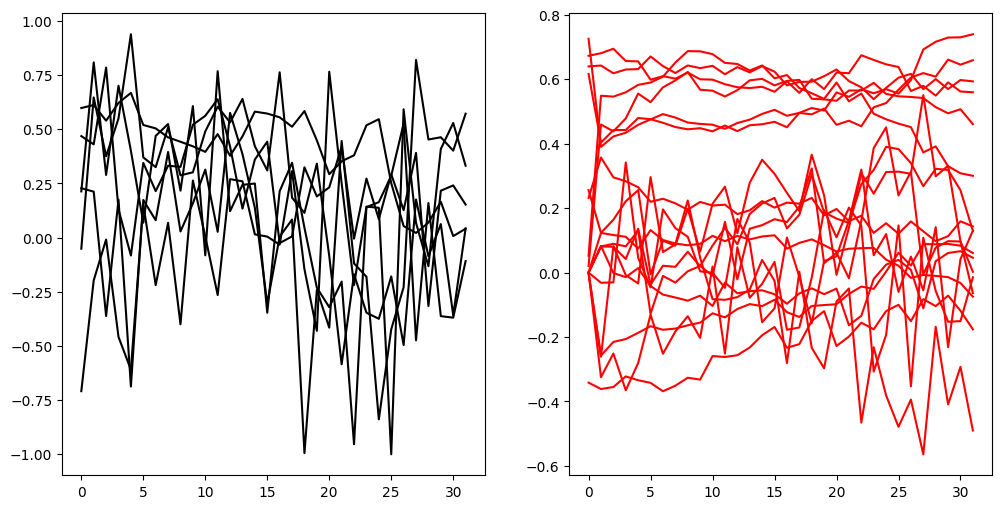

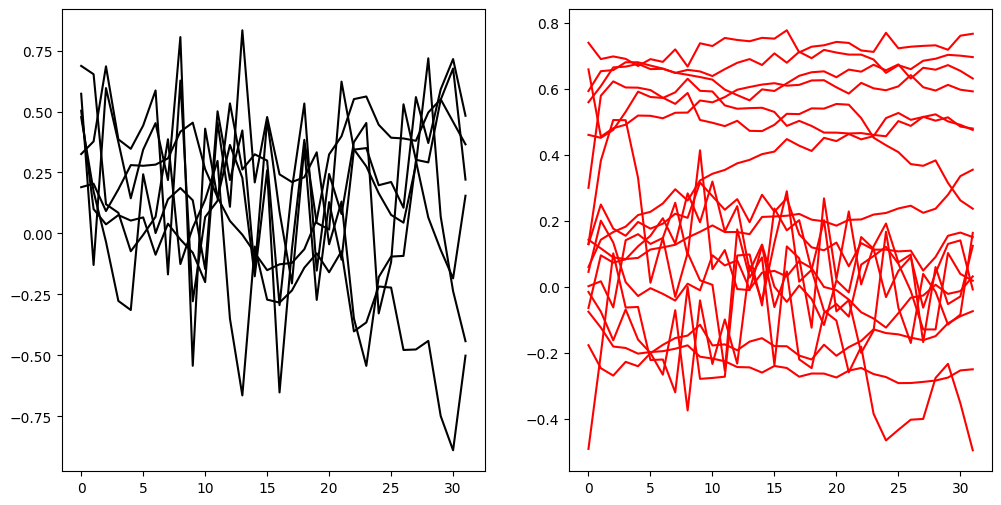

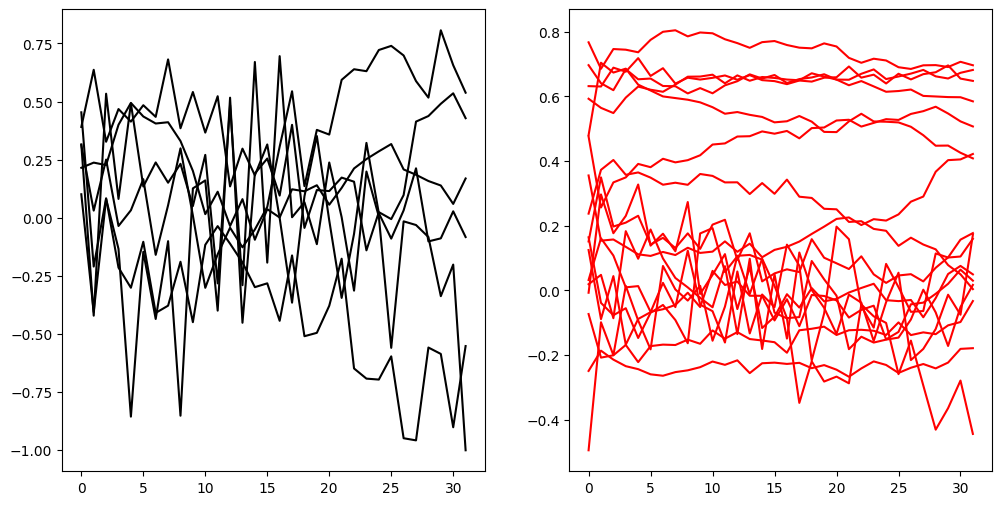

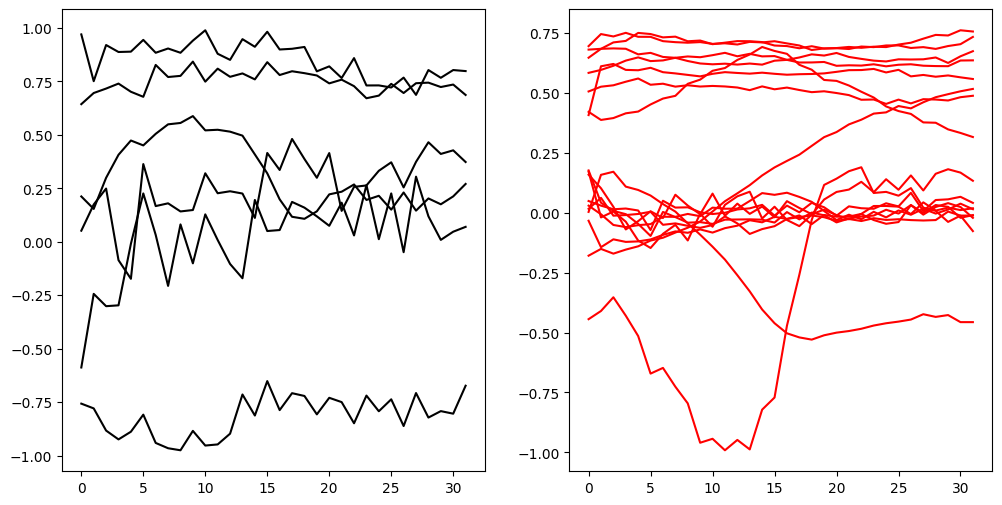

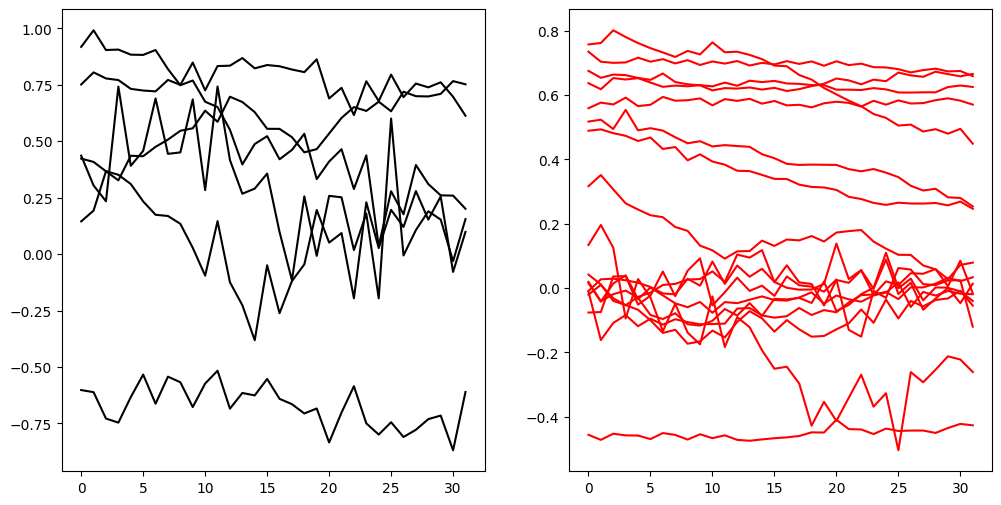

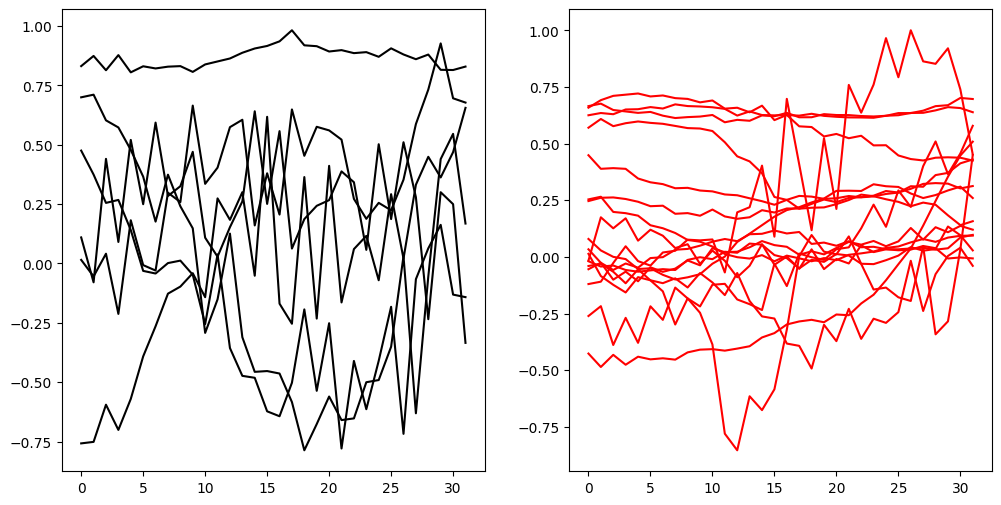

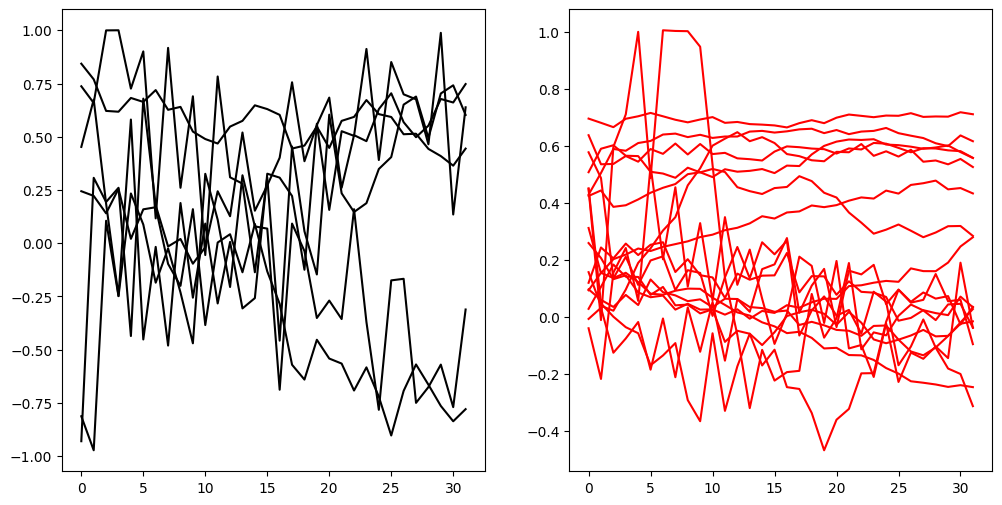

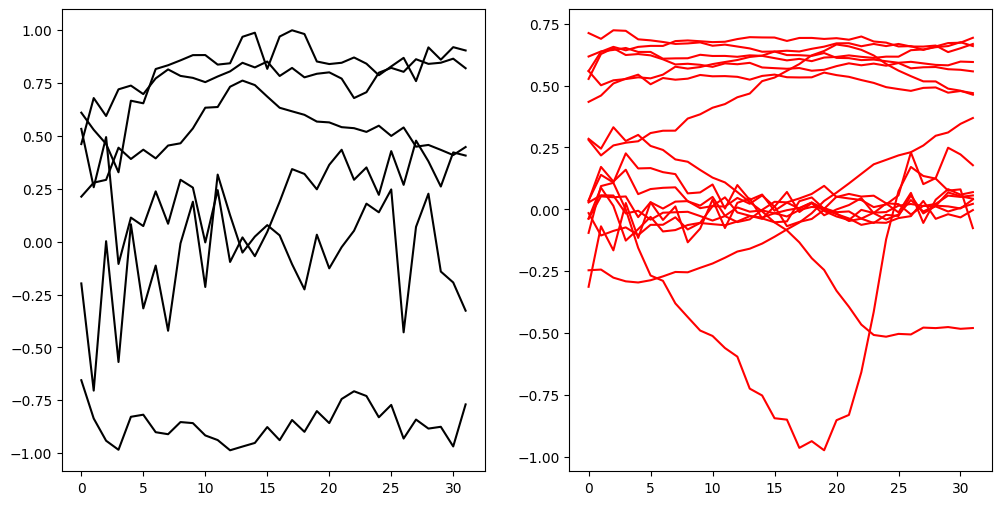

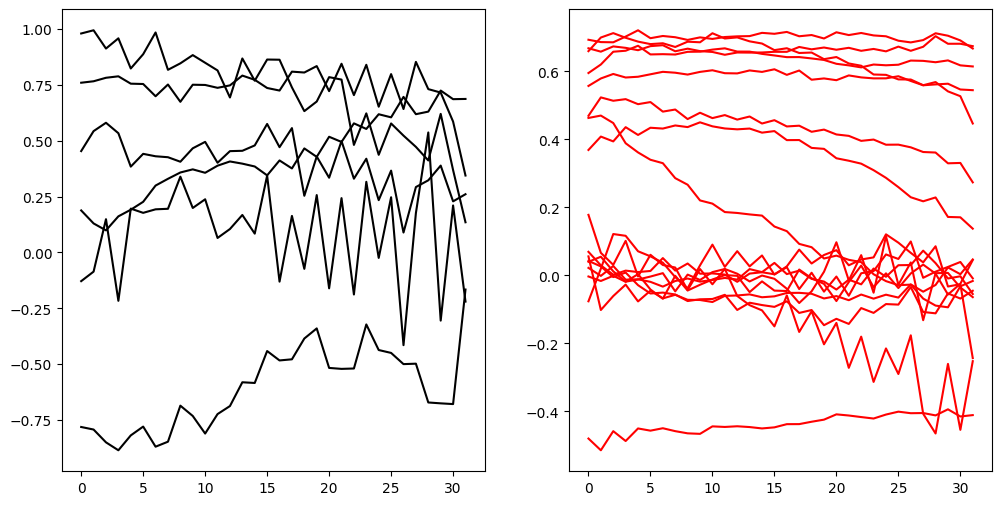

In [109]:
is_guide = True
env = gym.make('Walker2d-v4')
obs = env.reset()
obs = torch.as_tensor(obs, dtype=torch.float32)
obs = 2*(obs - mins[:-config['action_dim']])/(maxs[:-config['action_dim']] - mins[:-config['action_dim']]) - 1

generated_trajectory = None
for _ in range(20):
    if generated_trajectory is None:
        tau_0_u, tau_0, tau_unguided, tau_guided = PlanningTrajectory(obs, config, predict_epsilon)
    else:
        obs = tau[-1, :-config['action_dim']]
        obs = torch.as_tensor(obs, dtype=torch.float32)
        tau_0_u, tau_0, tau_unguided, tau_guided = PlanningTrajectory(obs, config, predict_epsilon)
    
    if is_guide:
        tau = tau_0
    else:
        tau = tau_0_u
    tau = tau.detach()
    displayInfo(tau, config)
    tau = tau.numpy()
    tau = tau.squeeze(0)
    
    if generated_trajectory is None:
        generated_trajectory = tau
    else:
        generated_trajectory = np.concatenate((generated_trajectory, tau[1:]), axis=0)

env.close()

print(generated_trajectory.shape)

In [26]:
env = gym.make('Walker2d-v4')

animation(generated_trajectory)

env.close()

SystemExit: 0

/mnt/c/Users/Hu/Desktop/CS/Codes/generativerl/rl/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [103]:
# compare generated trajectory with real trajectory

true value: tensor(70.5387)
tensor([71.0108], grad_fn=<SelectBackward0>) tensor([[70.3518]], grad_fn=<AddmmBackward0>) tensor([[70.7439]], grad_fn=<AddmmBackward0>)


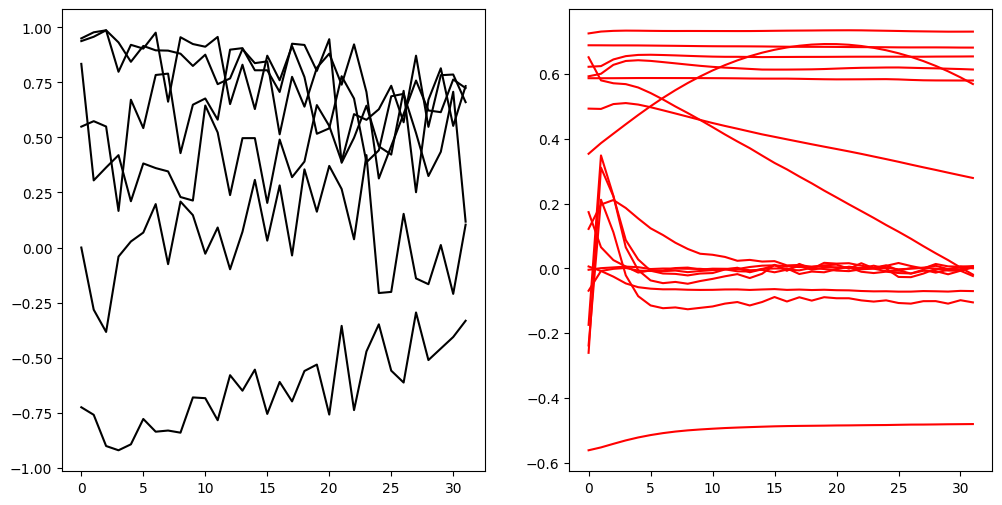

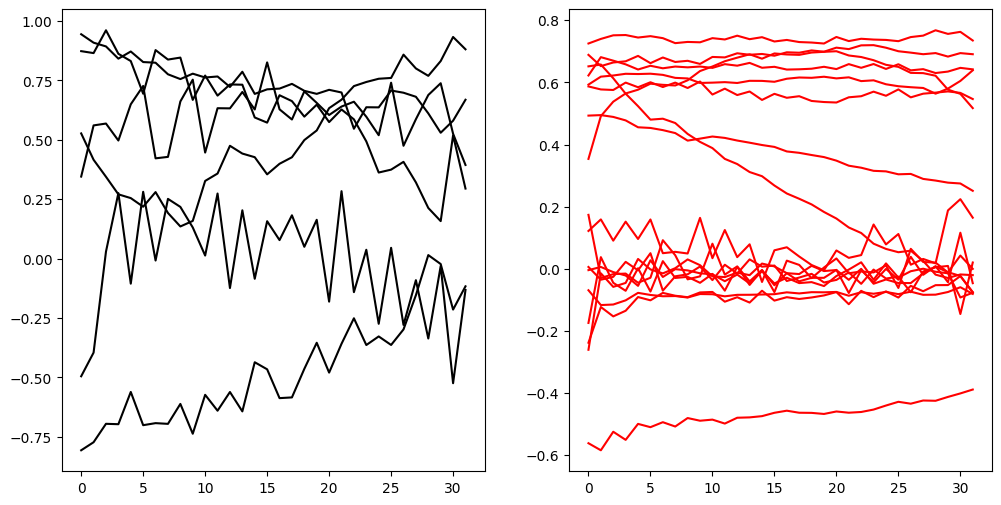

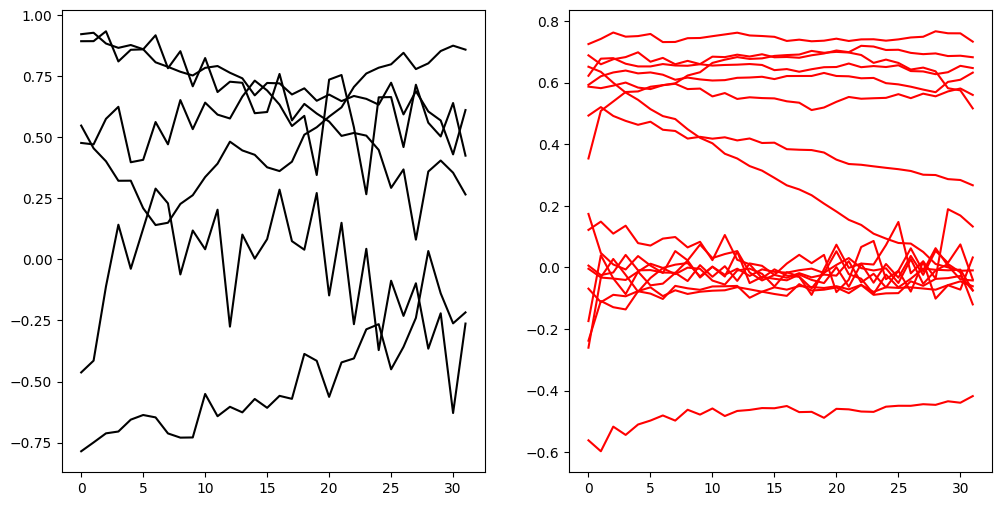

0
true value: tensor(80.8285)
tensor([79.5437], grad_fn=<SelectBackward0>) tensor([[79.3453]], grad_fn=<AddmmBackward0>) tensor([[79.7162]], grad_fn=<AddmmBackward0>)


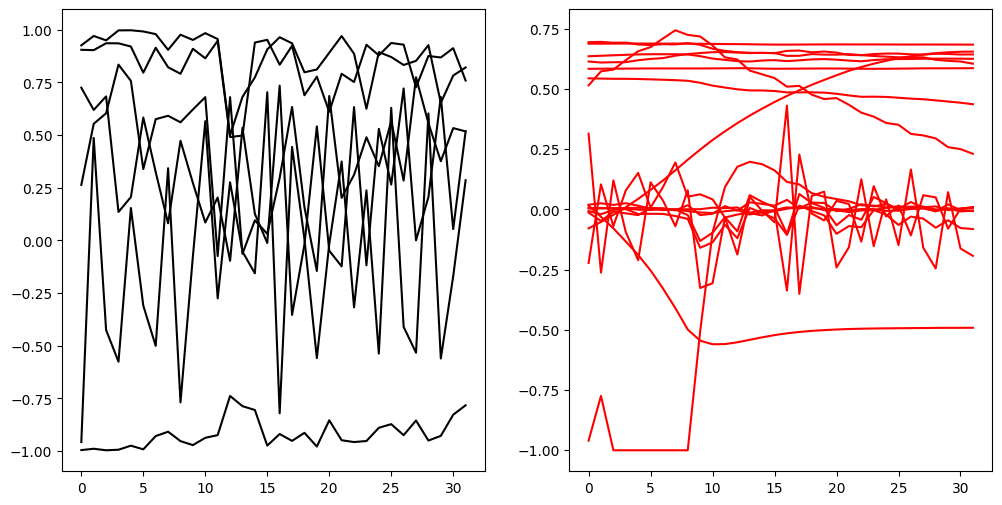

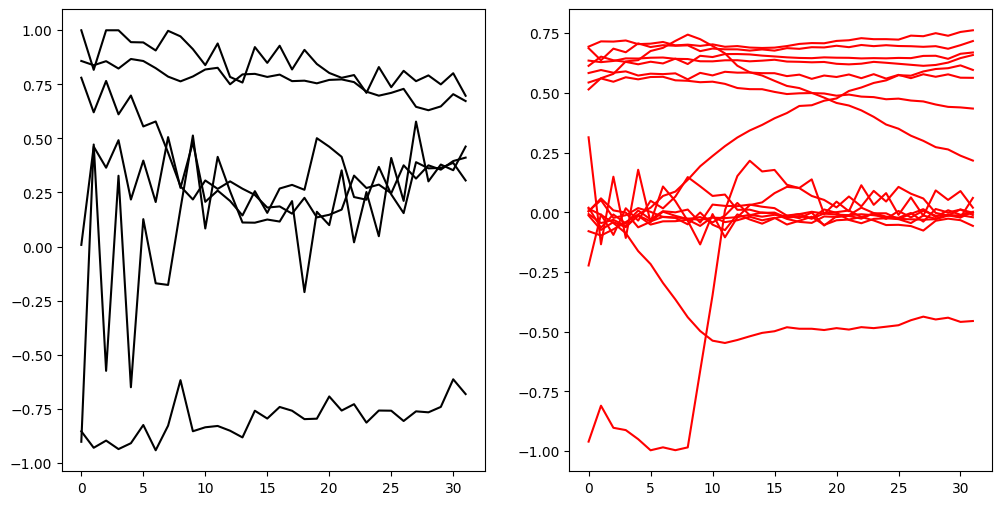

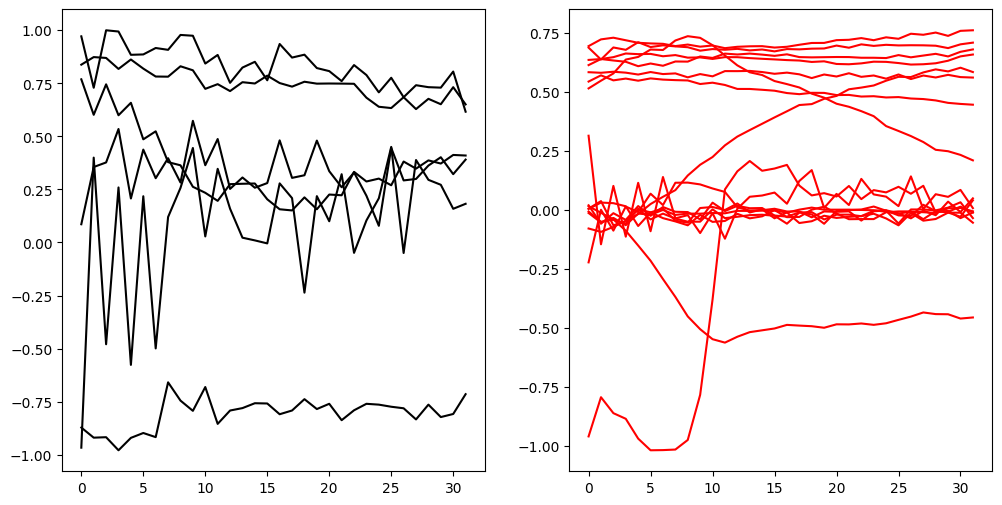

1
true value: tensor(27.5759)
tensor([27.4144], grad_fn=<SelectBackward0>) tensor([[27.3750]], grad_fn=<AddmmBackward0>) tensor([[27.4899]], grad_fn=<AddmmBackward0>)


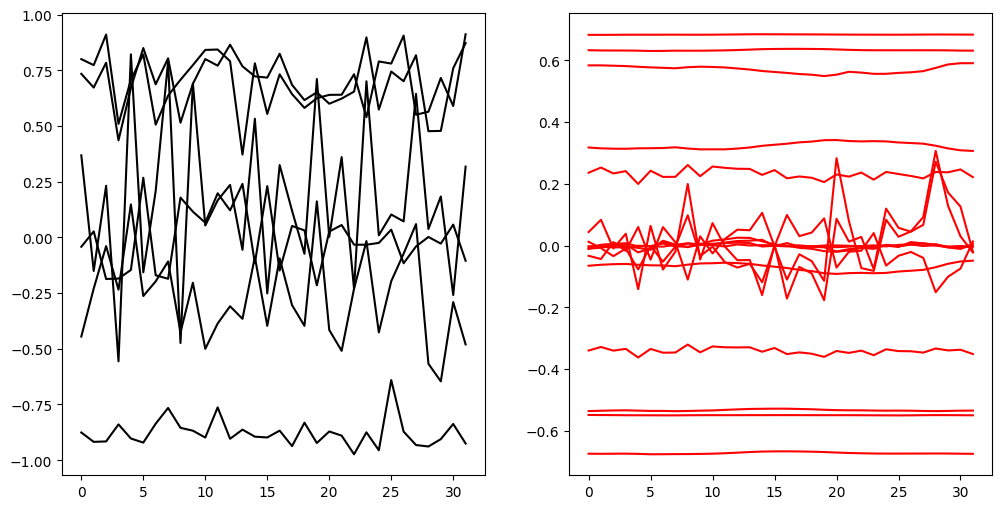

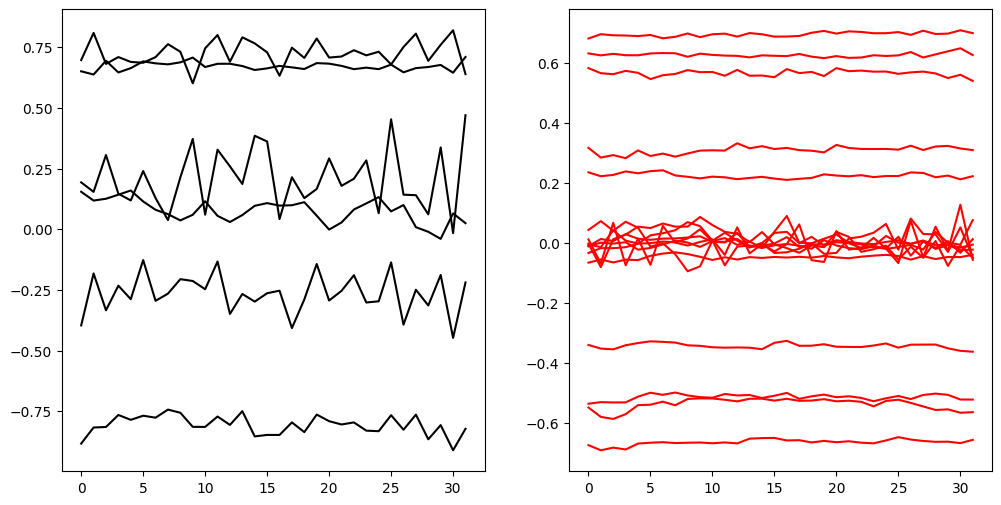

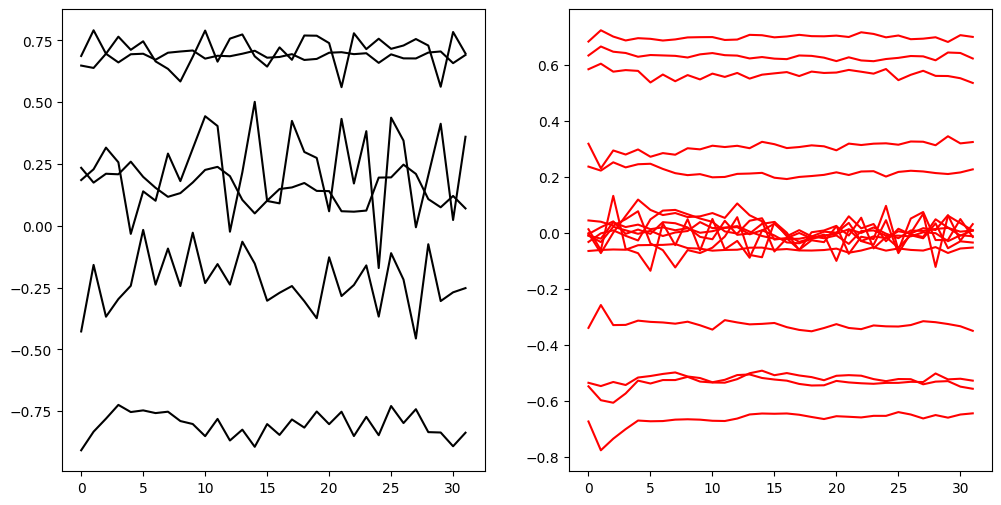

2
true value: tensor(106.6504)
tensor([107.6533], grad_fn=<SelectBackward0>) tensor([[106.5459]], grad_fn=<AddmmBackward0>) tensor([[106.9809]], grad_fn=<AddmmBackward0>)


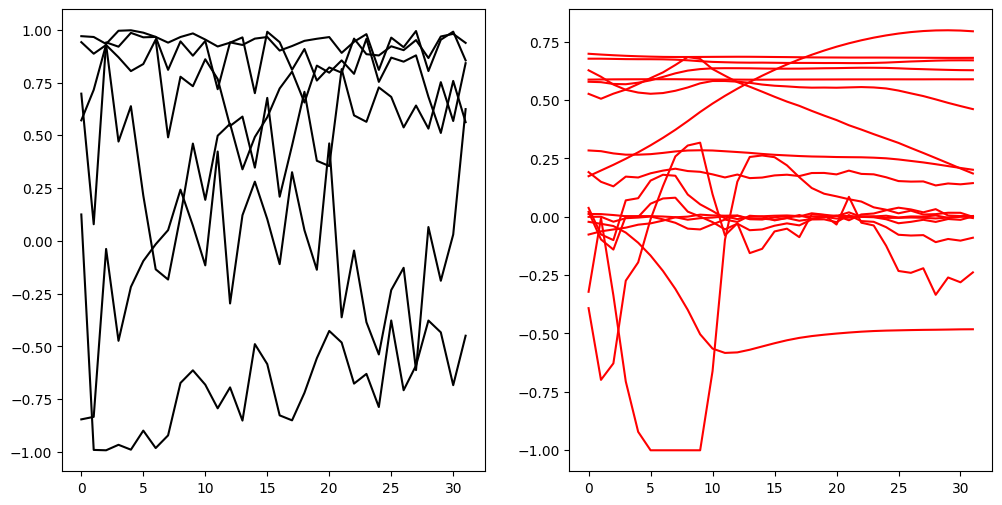

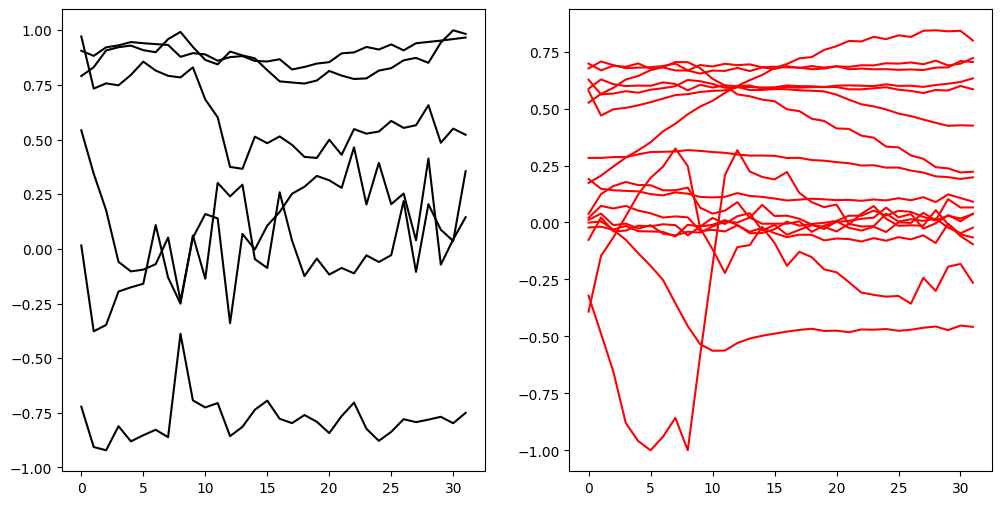

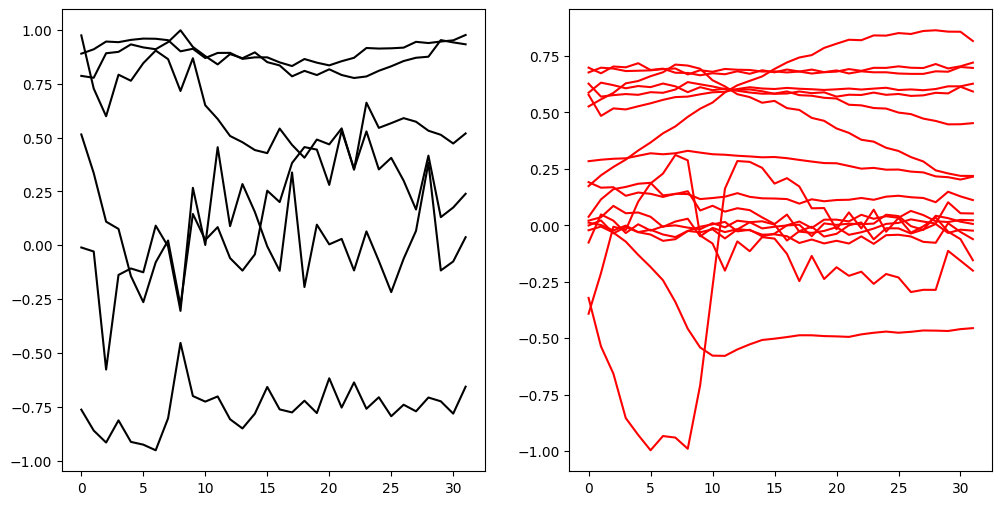

3


In [27]:
# torch.tensor([t], dtype=torch.float32, device=device)
#random.seed(42)
unnormalize = dataset.unnormalize
mins = dataset.mins
maxs = dataset.maxs

i = 0
for iteration, (tau_0, value) in enumerate(dataloader):
    v_0 = value_model(tau_0, 0, torch.tensor([0], dtype=torch.float32, device='cpu'))
    displayInfo(tau_0, config)
    
    s = tau_0[0, 0,:-config['action_dim']]
    tau_0_u, tau_0, tau_unguided, tau_guided = PlanningTrajectory(s, config, False)
    tau_0_u = tau_0_u.detach()
    tau_0 = tau_0.detach()
    
    displayInfo(tau_0_u, config)
    displayInfo(tau_0, config)

    tau_0_u = tau_0_u.float()
    tau_0 = tau_0.float()
    v_1 = value_model(tau_0_u, 0, torch.tensor([0], dtype=torch.float32, device='cpu'))
    v_2 = value_model(tau_0, 0, torch.tensor([0], dtype=torch.float32, device='cpu'))
    print('true value:', value[0])
    print(v_0[0], v_1, v_2)

    plt.show()
    print(i)
    i+=1
    if i > 3:
        break

**Testing in Env**

Cuda Testing

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
value_model = models['value_model'].to(device)
diffusion_model = models['diffusion_model'].to(device)

cuda


In [113]:
T_d = config['T_diffusion']
beta_t, alpha_t, alpha_bar_t, alpha_bar_tm1, sigma_t = schedule(cosine_beta_schedule, T_d, False, 0)

def q_posterior(x_start, x_t, t):
    posterior_mean = (beta_t[t] * torch.sqrt(alpha_bar_tm1[t]) / (1 - alpha_bar_t[t])) * x_start + \
                     (torch.sqrt(alpha_bar_t[t]) * (1 - alpha_bar_tm1[t]) / (1 - alpha_bar_t[t])) * x_t
    posterior_variance = beta_t[t] * (1 - alpha_bar_tm1[t]) / (1 - alpha_bar_t[t])
    posterior_log_variance_clipped = torch.log(torch.clamp(posterior_variance, min=1e-20))
    return posterior_mean, posterior_variance, posterior_log_variance_clipped


def p_sample(x, t, predict_epsilon=True):
    # Ensure inputs are tensors on the correct device
    if isinstance(x, np.ndarray):
        x = torch.tensor(x, device=device, dtype=torch.float32)
    t_tensor = torch.tensor([t], dtype=torch.float32, device=device)

    x_recon = diffusion_model(x, 0, t_tensor)
    if predict_epsilon:
        x_recon = (x - torch.sqrt(1 - alpha_bar_t[t]) * x_recon) / torch.sqrt(alpha_bar_t[t])
    x_recon.clamp_(-1., 1.)
    model_mean, _, model_log_variance = q_posterior(x_recon, x, t)
    model_std = torch.exp(0.5 * model_log_variance)

    noise = torch.randn_like(x) if t != 0 else torch.zeros_like(x)
    return model_mean + model_std * noise

def PlanningTrajectory(s, config, predict_epsilon):
    T_d = config['T_diffusion']
    tau_t = torch.randn(1, config['horizon'], config['transition_dim'], device=device)  # Ensure device
    tau_t[0, 0, :-config['action_dim']] = s

    tau_unguided = []
    tau_guided = []
    tau_t_u = tau_t.clone()  # Clone to keep the original for un-guided

    for t in reversed(range(0, T_d)):
        tau_t_u = p_sample(tau_t_u, t, predict_epsilon)
        tau_t_u[0, 0, :-config['action_dim']] = s
        
        # Gradient-Based Guidance
        tau_t.requires_grad_(True)
        tau_t = p_sample(tau_t, t, predict_epsilon)
        
        value = value_model(tau_t, 0, torch.tensor([t], dtype=torch.float32, device=device))
        value_grad = torch.autograd.grad(value.sum(), tau_t)[0]
        
        # Adjust the sample using the value gradient
        guidance_scale = 0.1
        tau_t = tau_t + guidance_scale * value_grad
        tau_t[0, 0, :-config['action_dim']] = s
        tau_t = tau_t.detach()

    return tau_t_u, tau_t, tau_unguided, tau_guided


In [134]:
import pickle
import numpy as np
import torch
from tqdm import tqdm
import gym

# Ensure the use of CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Real testing in env
unnormalize = dataset.unnormalize
min_values = dataset.mins
max_values = dataset.maxs
mins = torch.tensor(min_values, dtype=torch.float32, device=device)
maxs = torch.tensor(max_values, dtype=torch.float32, device=device)

def collectTrajectory(generated_trajectory, tau, actual_window_size):
    tau = tau.detach().cpu().numpy()  # Move to CPU before converting to numpy
    tau = tau.squeeze(0)

    if generated_trajectory is None:
        generated_trajectory = tau[:actual_window_size]
    else:
        generated_trajectory = np.concatenate((generated_trajectory, tau[:actual_window_size]), axis=0)
    return generated_trajectory

def takeAction(tau, i):
    if tau.shape[0] == 1:
        tau = tau.detach().cpu().numpy()  # Move to CPU before converting to numpy
        tau = tau.squeeze(0)
    action = tau[i, -config['action_dim']:]
    return action

def normalize_obs(observation):
    obs = torch.tensor(observation, device=device, dtype=torch.float32)  # Ensure obs is also float32
    normalized_obs = 2 * (obs - mins[:-config['action_dim']]) / (maxs[:-config['action_dim']] - mins[:-config['action_dim']]) - 1
    return normalized_obs


def test_model(models, config, env_name='Walker2d-v4', num_episodes=5, actual_window_size=1, is_guided=True):
    # Create the environment
    env = gym.make(env_name)

    # Loop through episodes for testing
    for episode in range(num_episodes):
        observation = env.reset()
        done = False
        value = 0

        terminated, truncated = False, False
        i = 0
        x_true = []
        x_pred = None
        k = 0
        while not (terminated):
        #while k<1000:
            k += 1
            if i == 0 or i == actual_window_size:  # Set the actual window size
                obs = normalize_obs(observation)
                tau_0_u, tau_0, _, _ = PlanningTrajectory(obs, config, False)
                
                if is_guided:
                    x_pred = collectTrajectory(x_pred, tau_0, actual_window_size)
                else:
                    x_pred = collectTrajectory(x_pred, tau_0_u, actual_window_size)
                i = 0
        
            if is_guided:
                action = takeAction(tau_0, i)
            else:
                action = takeAction(tau_0_u, i)
            i += 1
            
            # Step the environment with the action
            observation, reward, terminated, _ = env.step(action)
            value += reward
        
            # Normalize observation and ensure it is on CPU for storage
            obs = normalize_obs(observation)
            x_true.append(np.concatenate((obs.cpu().numpy(), torch.tensor(action, device=device).cpu().numpy())))  # Ensure both are on CPU

    env.close()
    x_true = np.asarray(x_true)
    return x_true, x_pred, value

In [40]:
print(torch.cuda.memory_allocated())  # Should show much lower usage now
print(torch.cuda.memory_reserved())

results = []
actual_window_sizes = [1, 2, 3, 4, 5, 6, 7]
nums = [10, 10, 10, 10, 10, 10, 10]  # Number of iterations for each window size

# Outer loop with tqdm to track the window sizes
for i, size in enumerate(tqdm(actual_window_sizes, desc='Window Sizes')):
    datas = []
    
    # Inner loop with tqdm to track the number of iterations for each window size
    for _ in tqdm(range(nums[i]), desc=f'Window Size {size}', leave=True, position=1, ncols=100):
        data = {}
        x_true, x_pred, value = test_model(models, config, env_name='Walker2d-v4', num_episodes=1, actual_window_size=size + 1, is_guided=False)
        data['unguided'] = (x_true, x_pred, value)
        x_true, x_pred, value = test_model(models, config, env_name='Walker2d-v4', num_episodes=1, actual_window_size=size + 1, is_guided=True)
        data['guided'] = (x_true, x_pred, value)
        datas.append(data)
    
    results.append(datas)

# Save results to a file
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

68401664
98566144


Window Sizes: 100%|███████████████████████████████████████████████████████████████████| 7/7 [3:34:42<00:00, 1840.36s/it]


In [172]:
import pandas as pd

v_rate_data = 4.9403
value_data = 4940.2729

# Load the pickle file using the pickle module
with open('results_1-7_all10.pkl', 'rb') as f:
    results = pickle.load(f)

# Initialize necessary variables
actual_window_sizes = [1, 2, 3, 4, 5, 6, 7]  # Adjust if different
values = []
v_rates = []

# Iterate over the results to compute means and v_rates
for i, result in enumerate(results):
    window_size = actual_window_sizes[i]
    value = []
    step = []

    for run in result:
        # Extract values for unguided runs
        unguided_value = run['unguided'][2]  # Assuming the 3rd element is 'value'
        value.append(unguided_value)
        step.append(len(run['unguided'][0]))  # Assuming unguided[0] is the trajectory length
    
    # Compute means for unguided runs
    values.append(np.mean(value))
    v_rates.append(sum(value) / sum(step))

    # Handle the guided instance for the last window (window_size == 7)
    if window_size == 7:
        guided_value = []  # To collect guided values
        guided_step = []   # To collect steps for guided runs
        
        for run in result:
            # Extract values for guided runs (if available for window size 7)
            guided_value.append(run['guided'][2])  # Assuming the 3rd element is 'value'
            guided_step.append(len(run['guided'][0]))  # Assuming guided[0] is the trajectory length
        
        # Compute means for guided runs
        values.append(np.mean(guided_value))
        v_rates.append(sum(guided_value) / sum(guided_step))
    
    # Display intermediate results
    print(f"Window Size {window_size}: Mean Value = {np.mean(value):.4f}, V-Rate = {sum(value) / sum(step):.4f}")

# Normalize values
values = np.array(values) / value_data
v_rates = np.array(v_rates) / v_rate_data


# Assuming actual_window_sizes, values, and v_rates are defined
df = pd.DataFrame({
    'Window Size': actual_window_sizes + ['Guided 7'],  # Include guided as a separate row
    'Normalized Score': values * 100,  # Multiplying scores by 100
    'Value Rate': v_rates
})

# Round the 'Score' and 'Value Rate' columns to 3 decimal places
df['Normalized Score'] = df['Normalized Score'].round(3)
df['Value Rate'] = df['Value Rate'].round(3)

# Display the results
print("\nFormatted Results:")
print(df.to_string(index=False))



Window Size 1: Mean Value = 4461.9377, V-Rate = 4.8190
Window Size 2: Mean Value = 3660.7400, V-Rate = 4.7716
Window Size 3: Mean Value = 3764.6957, V-Rate = 4.7824
Window Size 4: Mean Value = 4083.3252, V-Rate = 4.8152
Window Size 5: Mean Value = 4295.3235, V-Rate = 4.8278
Window Size 6: Mean Value = 3192.0946, V-Rate = 4.6812
Window Size 7: Mean Value = 3740.4791, V-Rate = 4.7504

Formatted Results:
Window Size  Normalized Score  Value Rate
          1            90.318       0.975
          2            74.100       0.966
          3            76.204       0.968
          4            82.654       0.975
          5            86.945       0.977
          6            64.614       0.948
          7            75.714       0.962
   Guided 7            84.065       0.971


/tmp/ipykernel_2317808/1953901038.py:35: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(x='Window Size', y='Value', hue='Type', data=df, dodge=True, jitter=True, color='black', marker='X', alpha=0.6)


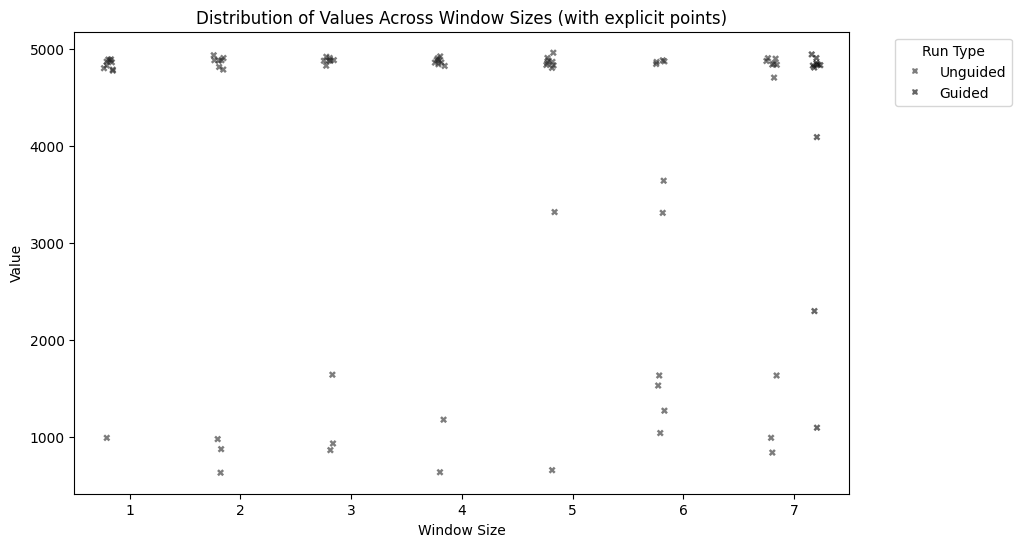

In [100]:
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load the pickle file using the pickle module
with open('results_1-7_all10.pkl', 'rb') as f:
    results = pickle.load(f)

# Prepare data for plotting
plot_data = []
actual_window_sizes = [1, 2, 3, 4, 5, 6, 7]  # Replace with the actual window sizes if different
for i, result in enumerate(results):
    window_size = actual_window_sizes[i]
    for run in result:
        # Extract values for unguided runs
        unguided_value = run['unguided'][2]  # Assuming the 3rd element is 'value'
        plot_data.append({'Window Size': window_size, 'Value': unguided_value, 'Type': 'Unguided'})

        if window_size == 7:
            # Extract values for guided runs
            guided_value = run['guided'][2]  # Assuming the 3rd element is 'value'
            plot_data.append({'Window Size': window_size, 'Value': guided_value, 'Type': 'Guided'})

# Convert to a DataFrame for easier plotting
df = pd.DataFrame(plot_data)

# Create a plot
plt.figure(figsize=(10, 6))

# Boxplot for distributions
#sns.boxplot(x='Window Size', y='Value', hue='Type', data=df, palette="Set2")

# Stripplot for explicit points
sns.stripplot(x='Window Size', y='Value', hue='Type', data=df, dodge=True, jitter=True, color='black', marker='X', alpha=0.6)

plt.title('Distribution of Values Across Window Sizes (with explicit points)')
plt.xlabel('Window Size')
plt.ylabel('Value')
plt.legend(title='Run Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
